
Benchmarking model: lighteternal/fact-or-opinion-xlmr-el
Using class mapping: {0: 'OPINION', 1: 'FACT'}
Loading model: lighteternal/fact-or-opinion-xlmr-el on cpu
Model loaded in 15.94 seconds
Run 1 completed in 1.1758s (avg 0.1176s per sentence)
Run 2 completed in 1.0199s (avg 0.1020s per sentence)
Run 3 completed in 1.1429s (avg 0.1143s per sentence)

Benchmarking model: GroNLP/mdebertav3-subjectivity-multilingual
Using class mapping: {0: 'FACT', 1: 'OPINION'}
Loading model: GroNLP/mdebertav3-subjectivity-multilingual on cpu
Model loaded in 10.95 seconds


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Run 1 completed in 5.1860s (avg 0.5186s per sentence)
Run 2 completed in 4.1453s (avg 0.4145s per sentence)
Run 3 completed in 4.3147s (avg 0.4315s per sentence)

Benchmarking model: prithivida/parrot_subjectivity_classifier
Using class mapping: {0: 'FACT', 1: 'OPINION'}
Loading model: prithivida/parrot_subjectivity_classifier on cpu
Error with model prithivida/parrot_subjectivity_classifier: prithivida/parrot_subjectivity_classifier is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

Benchmarking model: textattack/distilbert-base-uncased-MPQA
Using class mapping: {0: 'FACT', 1: 'OPINION'}
Loading model: textattack/distilbert-base-uncased-MPQA on cpu
Error with model textattack/distilbert-base-uncased-MPQA: textattack/distilbert-base-uncased-MPQA is not a local fold

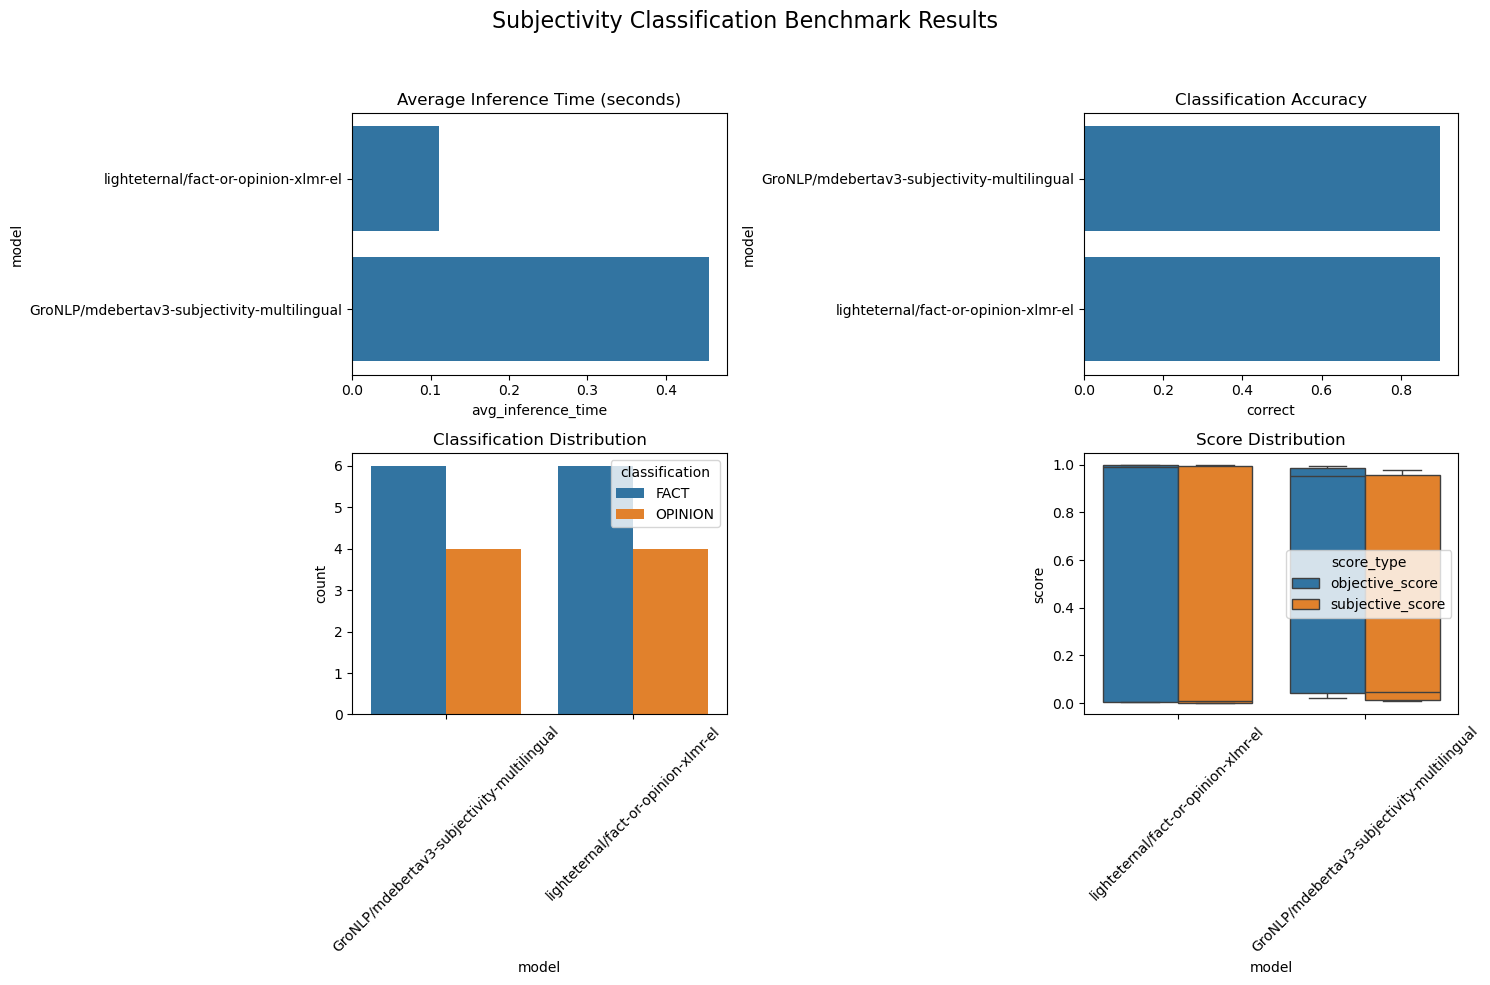

In [ ]:
import pandas as pd
import torch
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class SubjectivityClassifier:
    def __init__(self, model_name, device=None, class_mapping=None):
        """
        Initialize a subjectivity classifier with a specified pre-trained model.
        
        Args:
            model_name (str): Name of the pre-trained model to use
            device (str, optional): Device to run the model on ('cuda' or 'cpu')
            class_mapping (dict, optional): Mapping of model output indices to labels
                                           e.g., {0: "FACT", 1: "OPINION"} or {0: "OPINION", 1: "FACT"}
        """
        self.model_name = model_name
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        
        # Default class mapping (can be overridden)
        self.class_mapping = class_mapping or {0: "FACT", 1: "OPINION"}
        
        print(f"Loading model: {model_name} on {self.device}")
        load_start = time.time()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        load_end = time.time()
        print(f"Model loaded in {load_end - load_start:.2f} seconds")
        
        self.model.to(self.device)
        self.model.eval()
    
    def classify(self, text, return_time=False):
        """
        Classify text as subjective (opinion) or objective (fact).
        
        Args:
            text (str): Text to classify
            return_time (bool): Whether to return inference time
            
        Returns:
            dict: Classification results including scores and inference time if requested
        """
        start_time = time.time()
        
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        # Get probabilities
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        
        # Check if the model has 2 or more output classes
        if probs.shape[1] >= 2:
            obj_idx = list(self.class_mapping.keys())[list(self.class_mapping.values()).index("FACT")]
            subj_idx = list(self.class_mapping.keys())[list(self.class_mapping.values()).index("OPINION")]
            
            obj_score = probs[0][obj_idx].item()
            subj_score = probs[0][subj_idx].item()
            classification = "FACT" if obj_score > subj_score else "OPINION"
        else:
            # For single score models (rare)
            score = probs[0][0].item()
            # Apply class mapping
            if self.class_mapping[0] == "OPINION":
                subj_score = score
                obj_score = 1 - score
                classification = "OPINION" if score >= 0.5 else "FACT"
            else:
                obj_score = score
                subj_score = 1 - score
                classification = "FACT" if score >= 0.5 else "OPINION"
        
        end_time = time.time()
        inference_time = end_time - start_time
        
        result = {
            "text": text,
            "objective_score": obj_score,
            "subjective_score": subj_score,
            "classification": classification
        }
        
        if return_time:
            result["inference_time"] = inference_time
            
        return result

def benchmark_models(models, test_sentences, ground_truth=None, runs=3):
    """
    Benchmark multiple subjectivity classification models.
    
    Args:
        models (list): List of model configs to benchmark
                       Each config is a dict with 'name' and optional 'class_mapping'
        test_sentences (list): List of sentences to test
        ground_truth (dict, optional): Dict mapping sentences to ground truth labels
        runs (int): Number of runs for more reliable timing
        
    Returns:
        pandas.DataFrame: Benchmark results
    """
    all_results = []
    
    for model_config in models:
        model_name = model_config['name']
        class_mapping = model_config.get('class_mapping', {0: "FACT", 1: "OPINION"})
        
        print(f"\nBenchmarking model: {model_name}")
        print(f"Using class mapping: {class_mapping}")
        
        try:
            classifier = SubjectivityClassifier(model_name, class_mapping=class_mapping)
            
            # Warmup run
            for sentence in test_sentences:
                classifier.classify(sentence)
            
            # Benchmark runs
            model_times = []
            results = []
            
            for run in range(runs):
                batch_start = time.time()
                
                for sentence in test_sentences:
                    result = classifier.classify(sentence, return_time=True)
                    if run == 0:  # Only save classification results from first run
                        if ground_truth and sentence in ground_truth:
                            result["ground_truth"] = ground_truth[sentence]
                            result["correct"] = result["classification"] == ground_truth[sentence]
                        results.append(result)
                    model_times.append(result["inference_time"])
                
                batch_end = time.time()
                batch_time = batch_end - batch_start
                print(f"Run {run+1} completed in {batch_time:.4f}s (avg {batch_time/len(test_sentences):.4f}s per sentence)")
            
            # Calculate average inference time
            avg_time = np.mean(model_times)
            
            # Add model name and timing information to results
            for result in results:
                result["model"] = model_name
                result["avg_inference_time"] = avg_time
                all_results.append(result)
        
        except Exception as e:
            print(f"Error with model {model_name}: {str(e)}")
            continue
    
    # Create and return DataFrame
    df = pd.DataFrame(all_results)
    return df

def visualize_results(df, output_file="subjectivity_benchmark_visualization.pdf"):
    """
    Create visualizations for benchmark results.
    
    Args:
        df (pandas.DataFrame): Benchmark results
        output_file (str): File name for the visualization output
    """
    plt.figure(figsize=(15, 10))
    plt.suptitle("Subjectivity Classification Benchmark Results", fontsize=16)
    
    # 1. Inference time comparison
    plt.subplot(2, 2, 1)
    performance_df = df.groupby("model")["avg_inference_time"].mean().reset_index()
    performance_df = performance_df.sort_values("avg_inference_time")
    sns.barplot(x="avg_inference_time", y="model", data=performance_df)
    plt.title("Average Inference Time (seconds)")
    plt.tight_layout()
    
    # 2. Accuracy comparison (if ground truth available)
    if "correct" in df.columns:
        plt.subplot(2, 2, 2)
        accuracy_df = df.groupby("model")["correct"].mean().reset_index()
        accuracy_df = accuracy_df.sort_values("correct", ascending=False)
        sns.barplot(x="correct", y="model", data=accuracy_df)
        plt.title("Classification Accuracy")
        plt.tight_layout()
    
    # 3. Classification distribution
    plt.subplot(2, 2, 3)
    classification_counts = df.groupby(["model", "classification"]).size().reset_index(name="count")
    sns.barplot(x="model", y="count", hue="classification", data=classification_counts)
    plt.title("Classification Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # 4. Score distribution
    plt.subplot(2, 2, 4)
    # Melt the dataframe to get objective and subjective scores in one column
    score_df = df.melt(id_vars=["model", "text"], 
                       value_vars=["objective_score", "subjective_score"],
                       var_name="score_type", value_name="score")
    sns.boxplot(x="model", y="score", hue="score_type", data=score_df)
    plt.title("Score Distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the visualization
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to make room for the suptitle
    #plt.savefig(output_file)
    #print(f"Visualization saved to {output_file}")
    
    # For Jupyter notebooks, you can also display the plot
    # plt.show()

def calculate_accuracy_metrics(df):
    """
    Calculate accuracy metrics for each model.
    
    Args:
        df (pandas.DataFrame): Benchmark results with ground truth
    
    Returns:
        pandas.DataFrame: Accuracy metrics
    """
    if "ground_truth" not in df.columns:
        return None
    
    metrics = []
    
    for model_name in df["model"].unique():
        model_df = df[df["model"] == model_name]
        
        total = len(model_df)
        correct = sum(model_df["correct"])
        accuracy = correct / total if total > 0 else 0
        
        # Calculate precision, recall, F1 for each class
        for classification in ["FACT", "OPINION"]:
            true_positives = len(model_df[(model_df["classification"] == classification) & 
                                          (model_df["ground_truth"] == classification)])
            
            predicted_positives = len(model_df[model_df["classification"] == classification])
            actual_positives = len(model_df[model_df["ground_truth"] == classification])
            
            precision = true_positives / predicted_positives if predicted_positives > 0 else 0
            recall = true_positives / actual_positives if actual_positives > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            metrics.append({
                "model": model_name,
                "class": classification,
                "precision": precision,
                "recall": recall,
                "f1": f1
            })
        
        # Overall accuracy
        metrics.append({
            "model": model_name,
            "class": "Overall",
            "accuracy": accuracy,
            "correct": correct,
            "total": total
        })
    
    return pd.DataFrame(metrics)

# Main execution
if __name__ == "__main__":
    # Test sentences with ground truth (mix of clear facts and opinions)
    test_sentences_with_labels = {
        "The Earth revolves around the Sun.": "FACT",
        "I think this movie is absolutely terrible.": "OPINION",
        "Water boils at 100 degrees Celsius at sea level.": "FACT",
        "In my opinion, the government should increase funding for education.": "OPINION",
        "Paris is the capital of France.": "FACT",
        "This is probably the best restaurant in town.": "OPINION",
        "The movie Inception was released in 2010.": "FACT",
        "Chocolate ice cream tastes better than vanilla.": "OPINION",
        "The Eiffel Tower is located in Paris.": "FACT",
        "I believe that exercise is crucial for maintaining good health.": "OPINION"
    }
    
    test_sentences = list(test_sentences_with_labels.keys())
    ground_truth = test_sentences_with_labels
    
    # Models to benchmark with appropriate class mappings
    models = [
        # First model has swapped classes (as noted in your description)
        {"name": "lighteternal/fact-or-opinion-xlmr-el", "class_mapping": {0: "OPINION", 1: "FACT"}},
        {"name": "GroNLP/mdebertav3-subjectivity-multilingual"},
        {"name": "prithivida/parrot_subjectivity_classifier"},
        {"name": "textattack/distilbert-base-uncased-MPQA"},
        {"name": "yuriykatko/subjectivity-classifier"}
    ]
    
    # Run benchmark
    results_df = benchmark_models(models, test_sentences, ground_truth)
    
    # Calculate accuracy metrics
    metrics_df = calculate_accuracy_metrics(results_df)
    
    # Display performance summary
    print("\nPerformance Summary:")
    performance_df = results_df.groupby("model")["avg_inference_time"].mean().reset_index()
    performance_df = performance_df.sort_values("avg_inference_time")
    print(performance_df)
    
    # Display accuracy metrics
    if metrics_df is not None:
        print("\nAccuracy Metrics:")
        overall_metrics = metrics_df[metrics_df["class"] == "Overall"]
        print(overall_metrics[["model", "accuracy", "correct", "total"]])
        
        print("\nClass-specific Metrics:")
        class_metrics = metrics_df[metrics_df["class"] != "Overall"]
        print(class_metrics)
    
    # Save results to CSV
    results_df.to_csv("subjectivity_benchmark_results.csv", index=False)
    print("\nDetailed results saved to 'subjectivity_benchmark_results.csv'")
    
    if metrics_df is not None:
        metrics_df.to_csv("subjectivity_metrics.csv", index=False)
        print("Metrics saved to 'subjectivity_metrics.csv'")
    
    # Create visualizations
    visualize_results(results_df)

In [4]:
results_df.head()

,text,objective_score,subjective_score,classification,inference_time,ground_truth,correct,model,avg_inference_time
0,The Earth revolves around the Sun.,0.998072,0.001928,FACT,0.076338,FACT,True,lighteternal/fact-or-opinion-xlmr-el,0.111187
1,I think this movie is absolutely terrible.,0.002820,0.997180,OPINION,0.099539,OPINION,True,lighteternal/fact-or-opinion-xlmr-el,0.111187
2,Water boils at 100 degrees Celsius at sea level.,0.996902,0.003098,FACT,0.100277,FACT,True,lighteternal/fact-or-opinion-xlmr-el,0.111187
3,"In my opinion, the government should increase ...",0.005883,0.994117,OPINION,0.105572,OPINION,True,lighteternal/fact-or-opinion-xlmr-el,0.111187
4,Paris is the capital of France.,0.998130,0.001870,FACT,0.113535,FACT,True,lighteternal/fact-or-opinion-xlmr-el,0.111187
